In [478]:
import numpy as np
import imutils
from matplotlib import pyplot as plt
import cv2
import itertools

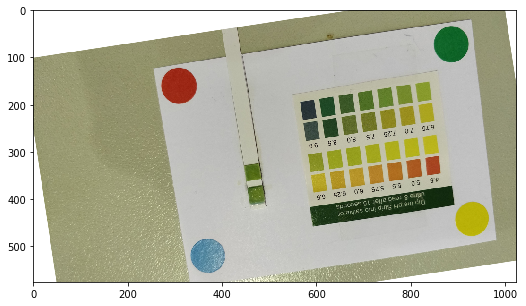

In [500]:
image = imutils.resize(cv2.imread('Data/rotated.jpg'), width=1024)
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [501]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

param1 = 30
param2 = 90
for i in range(0, 100, 1):
    par1 = param1+(i / 2 + i % 2)
    par2 = param2-(i / 2 + ((i + 1) % 2))
    circles = cv2.HoughCircles(gray_image,cv2.HOUGH_GRADIENT,1,20,
                            param1=par1,param2=par2,minRadius=20,maxRadius=50)
    # print(circles.shape if circles is not None else "None")
    if (circles is not None) and circles.shape[1] == 4:
        print(circles.shape)
        break
if not ((circles is not None) and circles.shape[1] == 4):
    print("Failed")

(1, 4, 3)


In [502]:
circled = image.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(circled,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(circled,(i[0],i[1]),1,(0,0,255),2)

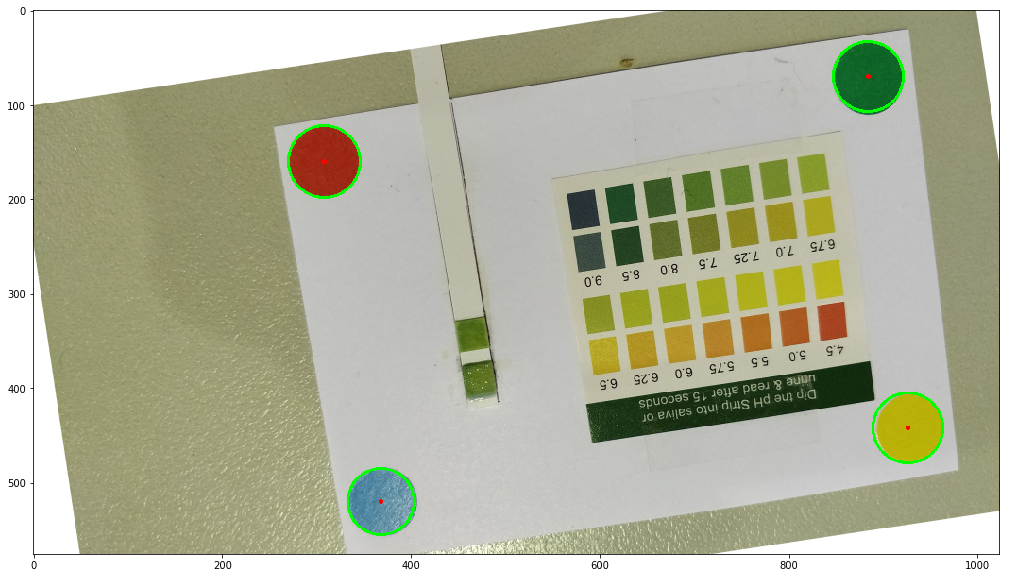

In [503]:
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(circled, cv2.COLOR_BGR2RGB))
plt.show()

In [505]:
def color_dist(col_temp, col_match):
    return np.sum(np.abs(col_temp - col_match))       

def find_perm(array_match):
    yellow = [255,255,0]
    blue = [65,105,225]
    green = [50,205,50]
    red = [255,0,0]
    array_template = np.array([[yellow, blue, red, green]])

    perm_list = list(itertools.permutations([0,1,2,3]))
    distances_list = []
    for perm in perm_list:
        total_dist = 0
        for i in range(4):
            total_dist += color_dist(array_match[0][perm[i]], array_template[0][i])
        distances_list.append(total_dist)
    min_index = np.argmin(np.array(distances_list))
    perm = perm_list[min_index]
    return perm

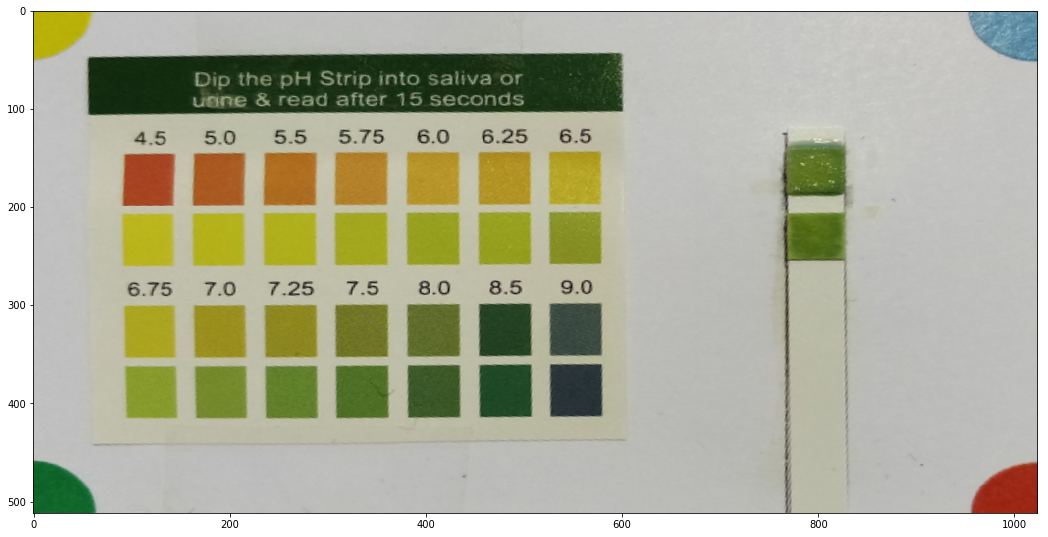

In [516]:
array2 = [[list(reversed(image[i[1], i[0]])) for i in circles[0,:]]]
array_match = np.array(array2)
perm = find_perm(array_match)

def get_pos(coord):
    return (coord[0], coord[1])

def create_map(circles):
    coords = [get_pos(circles[0,:][perm[i]]) for i in range(4)]
    return np.array(coords)

coords = create_map(circles)

positions = np.array([(0,0), (1024,0), (1024,512), (0,512)])
h, status = cv2.findHomography(coords, positions)

cropped = cv2.warpPerspective(image, h, (1024, 512))
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

[[[166, 66, 30], [167, 86, 30], [170, 107, 29], [178, 128, 41], [181, 147, 40], [179, 149, 38], [193, 175, 49]], [[184, 179, 27], [177, 176, 24], [174, 174, 26], [163, 167, 30], [148, 157, 28], [150, 157, 28], [134, 143, 34]], [[171, 164, 31], [156, 145, 30], [145, 138, 34], [114, 119, 38], [96, 107, 47], [32, 63, 31], [58, 73, 66]], [[136, 154, 44], [116, 137, 42], [98, 128, 42], [81, 113, 40], [59, 89, 39], [32, 73, 39], [37, 48, 52]]]


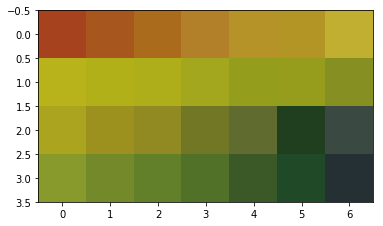

In [521]:
colors = []
for i, y in enumerate([180, 240, 320, 380]):
    colors.append([])
    for x in range(100, 600, 75):
        colors[i].append(list(reversed(cropped[y, x])))
plt.imshow(colors)
print(colors)

[[[100, 122, 40], [87, 111, 23]]]


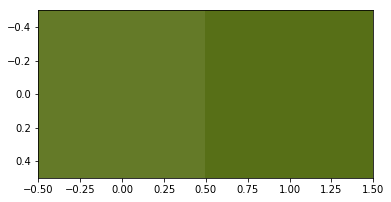

In [439]:
matches = [[list(reversed(cropped[80, 420])), list(reversed(cropped[120, 420]))]]
print(matches)
plt.imshow(matches)

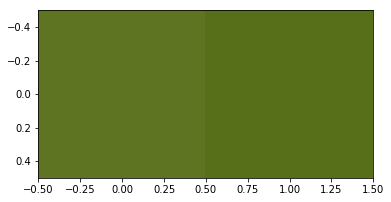